# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [ ]:
import numpy as np
import pandas as pd

class MyBinaryLogisticRegression:
    def __init__(self, regularization=None, optimizer='gd', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if optimizer not in ['newton', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{optimizer}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        self.regularization = regularization
        self.optimizer = optimizer
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.coefs_ = None
        self.feature_names_in_ = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _loss_grad_hess(self, X, y, w):
        n = X.shape[0]
        p = self._sigmoid(X @ w)

        grad = X.T @ (p - y) / n
        hess = (X.T @ (np.diag(p * (1 - p))) @ X) / n

        if self.regularization in ("l2", "l1l2"):
            grad += 2 * self.lambda_2 * w
            hess += 2 * self.lambda_2 * np.eye(len(w))

        if self.regularization in ("l1", "l1l2"):
            grad += self.lambda_1 * np.sign(w)

        return grad, hess

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        np.random.seed(42)

        self.feature_names_in_ = X.columns
        X = X.values
        y = y.values

        X = np.c_[np.ones(X.shape[0]), X]
        self.coefs_ = np.zeros(X.shape[1])

        for i in range(1000):
            w_old = self.coefs_.copy()

            if self.optimizer == "gd":
                grad, _ = self._loss_grad_hess(X, y, self.coefs_)
                self.coefs_ -= 0.01 * grad

            elif self.optimizer == "sgd":
                idx = np.random.choice(X.shape[0], self.batch_size, replace=False)
                grad, _ = self._loss_grad_hess(X[idx], y[idx], self.coefs_)
                self.coefs_ -= 0.01 * grad

            elif self.optimizer == "newton":
                grad, hess = self._loss_grad_hess(X, y, self.coefs_)
                try:
                    self.coefs_ -= np.linalg.solve(hess, grad)
                except np.linalg.LinAlgError:
                    break
            else:
                raise ValueError("Неизвестный оптимизатор")

            if np.linalg.norm(self.coefs_ - w_old) < 1e-6:
                break

        return self

    def predict(self, X: np.array):
        X = np.c_[np.ones(X.shape[0]), X]
        proba = self._sigmoid(X @ self.coefs_)
        return (proba >= 0.5).astype(int)

    def score(self, X: np.array, y: np.array):
        y_pred = self.predict(X)

        tp = np.sum((y_pred == 1) & (y == 1))
        fp = np.sum((y_pred == 1) & (y == 0))
        fn = np.sum((y_pred == 0) & (y == 1))

        if tp == 0:
            return 0.0

        precision = float(tp) / float(tp + fp)
        recall = float(tp) / float(tp + fn)

        return 2 * precision * recall / (precision + recall)

In [ ]:
class MyTargetEncoder:
    def __init__(self, cols, smoothing=10.0):
        self.cols = cols
        self.smoothing = smoothing
        self.global_mean_ = None
        self.encoding_ = {}
        self.feature_names_in_ = None
        self.feature_names_out_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.feature_names_in_ = list(X.columns)

        self.global_mean_ = y.mean()
        self.encoding_ = {}
        y = np.asarray(y).flatten()

        for col in self.cols:
            df = pd.DataFrame({
                col: X[col],
                "target": y
            })

            stats = (
                df.groupby(col)["target"]
                  .agg(["mean", "count"])
                  .astype(float)
            )

            denom = stats["count"] + self.smoothing
            denom = denom.replace(0, np.nan)

            smooth = (
                (stats["count"] * stats["mean"] +
                self.smoothing * self.global_mean_[0]) / denom
            )

            self.encoding_[col] = smooth.to_dict()

        self.feature_names_out_ = self.feature_names_in_.copy()
        return self

    def transform(self, X: pd.DataFrame):
        X_enc = X.copy()

        for col in self.cols:
            X_enc[col] = (
                X[col]
                .map(self.encoding_[col])
                .fillna(self.global_mean_)
            )

        return X_enc

    def fit_transform(self, X: pd.DataFrame, y: pd.Series):
        self.fit(X, y)
        return self.transform(X)

    def get_feature_names_out(self):
        return self.feature_names_out_


L1 регуляризация требует выпуклости, непрерывности и существования субградиента от штрафной функции, поэтому можно использовать градиентные методы, но нельзя применять метод Ньютона. L2 требует дважды дифференциируемую, выпуклую функцию, что выполняется для всех трех методов.

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [ ]:
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 120,
})

data = pd.read_csv('penguins_binary_classification.csv', delimiter=',')
df = data
#сначала используем данные с нашим target encoder
X, y = df.drop(columns=['species']), df[['species']]
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

encoder = MyTargetEncoder(cat_cols)
scaler = MinMaxScaler()
y_encoder = OneHotEncoder(drop='first', sparse_output=False)
X, y = df.drop(columns=['species']), df[['species']]

y = y_encoder.fit_transform(y)
y = pd.DataFrame(y, columns=y_encoder.get_feature_names_out())
X_cat_cols = encoder.fit_transform(X[cat_cols], y)
X_num_cols = scaler.fit_transform(X[num_cols])

X_cat_cols = pd.DataFrame(X_cat_cols, columns=encoder.get_feature_names_out())
X_num_cols = pd.DataFrame(X_num_cols, columns=scaler.get_feature_names_out())
X = pd.concat([X_cat_cols, X_num_cols], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y['species_Gentoo'], test_size=0.2, random_state=42)

/tmp/ipython-input-431956054.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.smoothing * self.global_mean_[0]) / denom


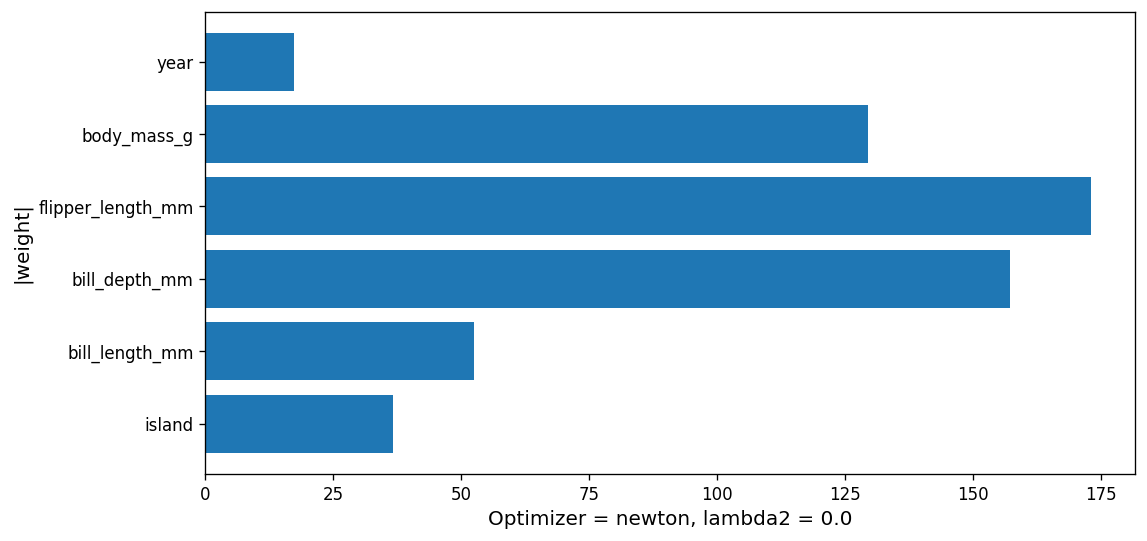

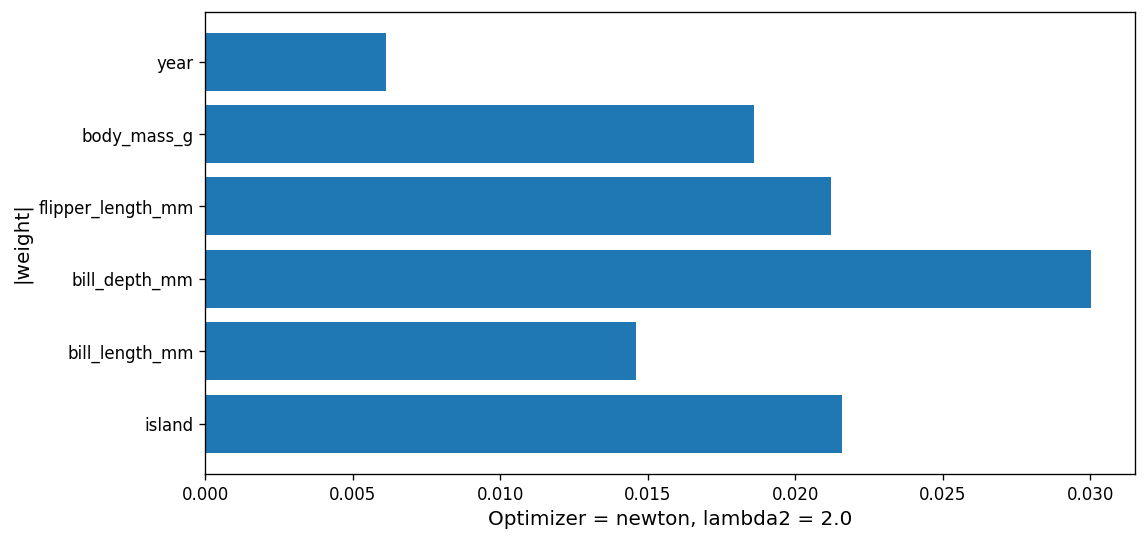

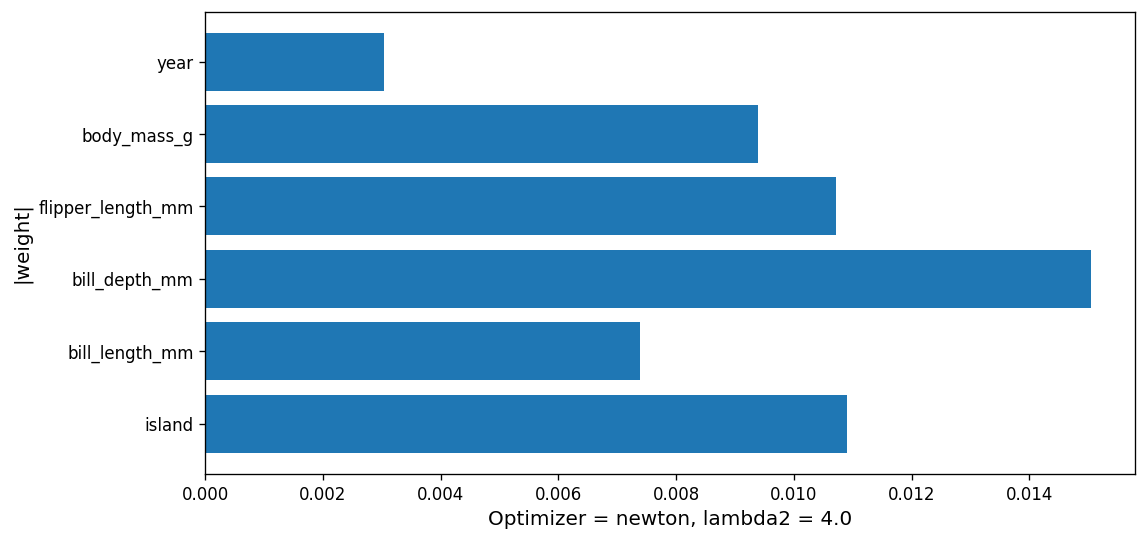

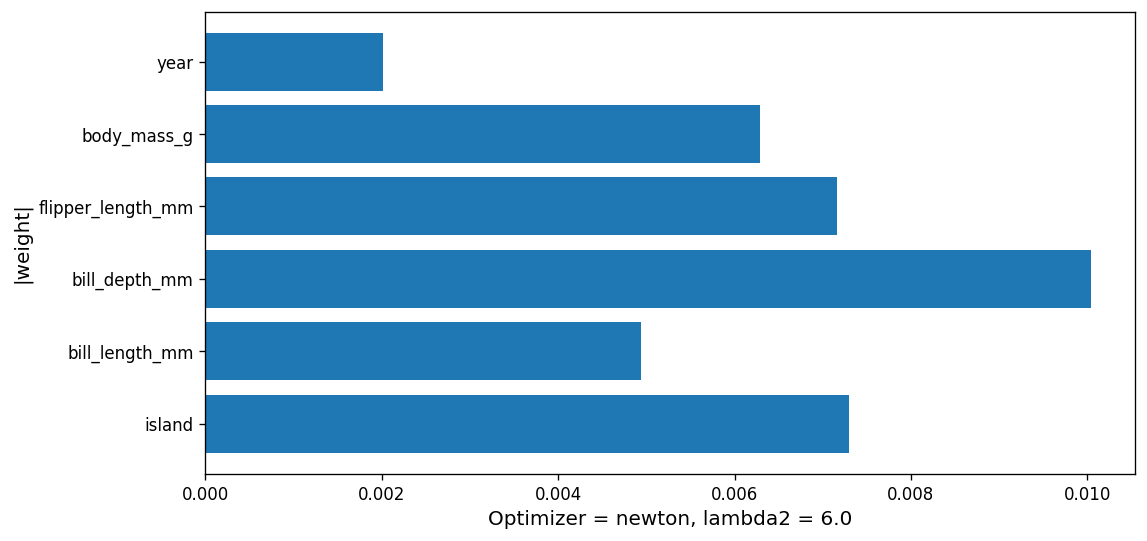

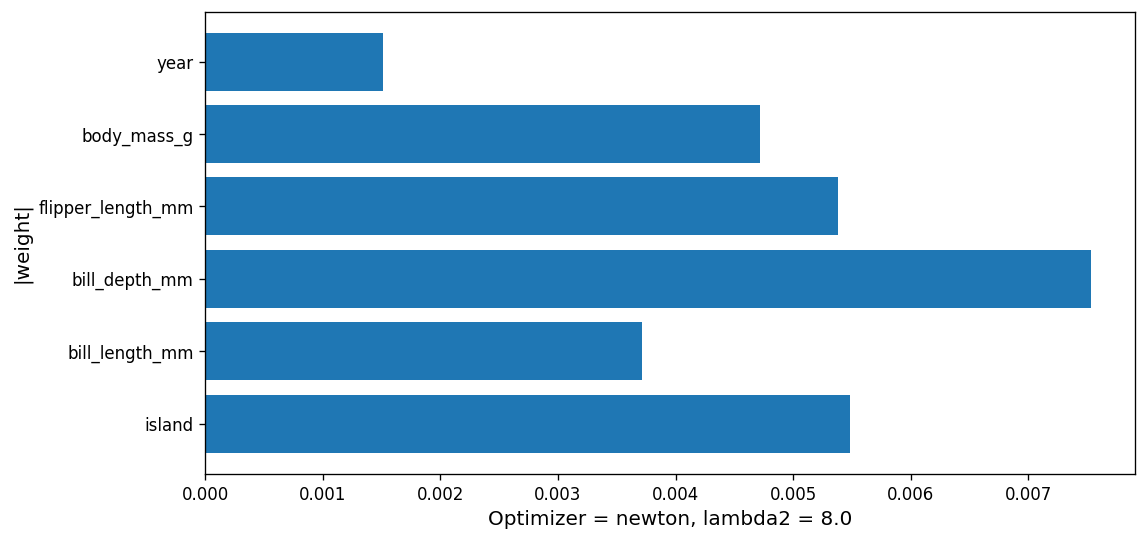

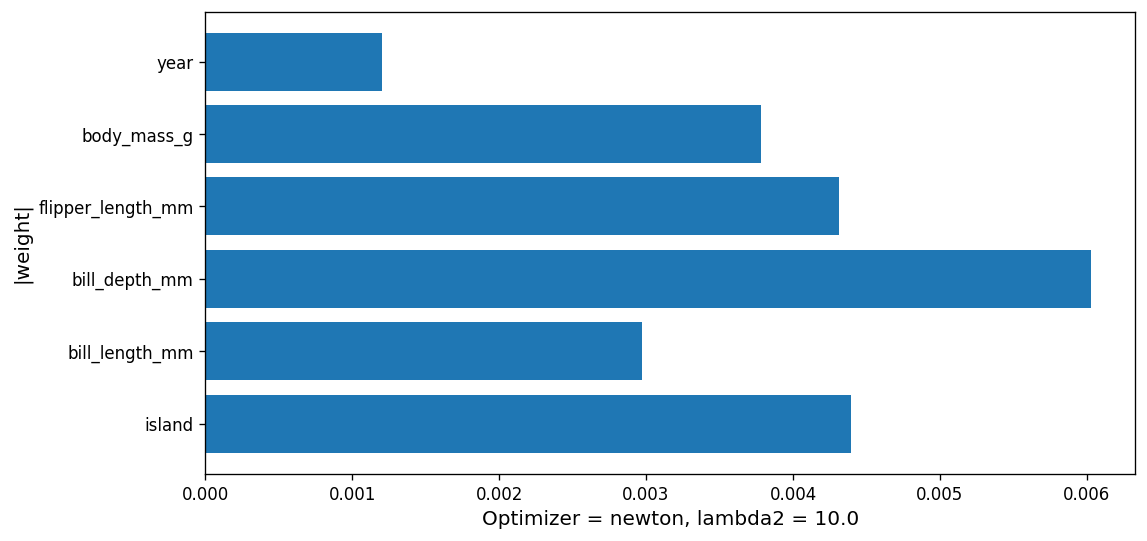

In [ ]:
from sklearn.metrics import accuracy_score

lambdas1 = np.arange(0, 10.1, 0.2)

train_acc_new, val_acc_new, f1_score_new, train_time_new = [],[],[],[]

for l in lambdas1:
    model = MyBinaryLogisticRegression('l2', 'newton', 1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time_new.append(time.time() - t)

    score = model.score(X_test, y_test)
    f1_score_new.append(score)
    val_acc_new.append(accuracy_score(y_test, model.predict(X_test)))
    train_acc_new.append(accuracy_score(y_train, model.predict(X_train)))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_[1:].flatten()))
        plt.xlabel("Optimizer = newton, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

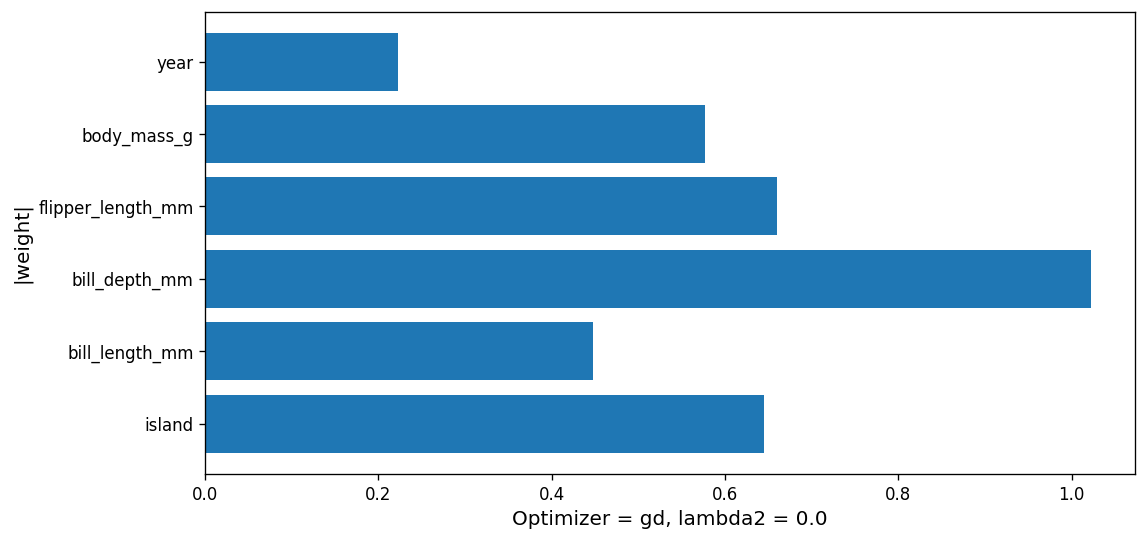

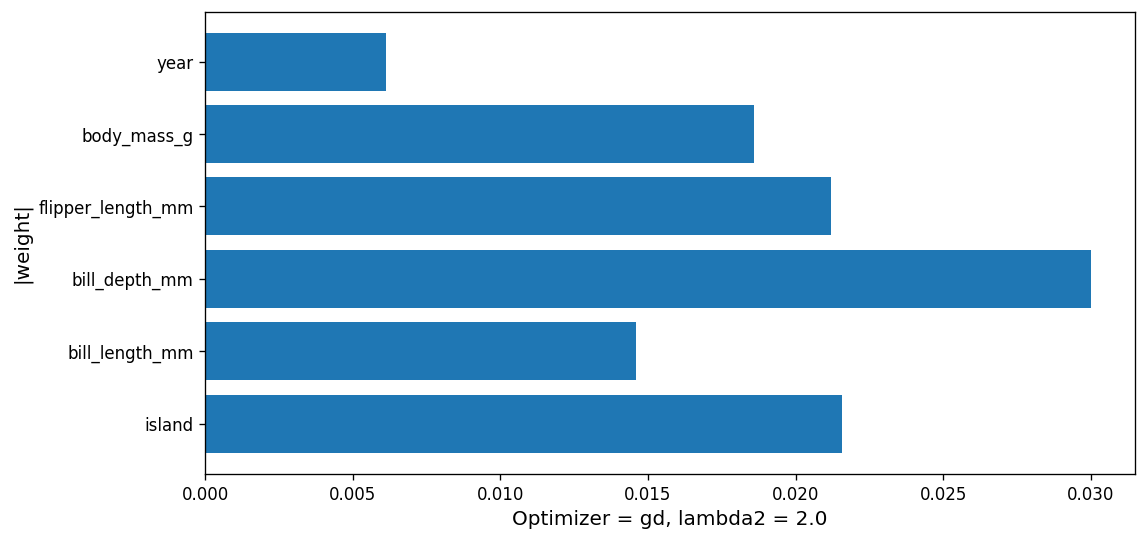

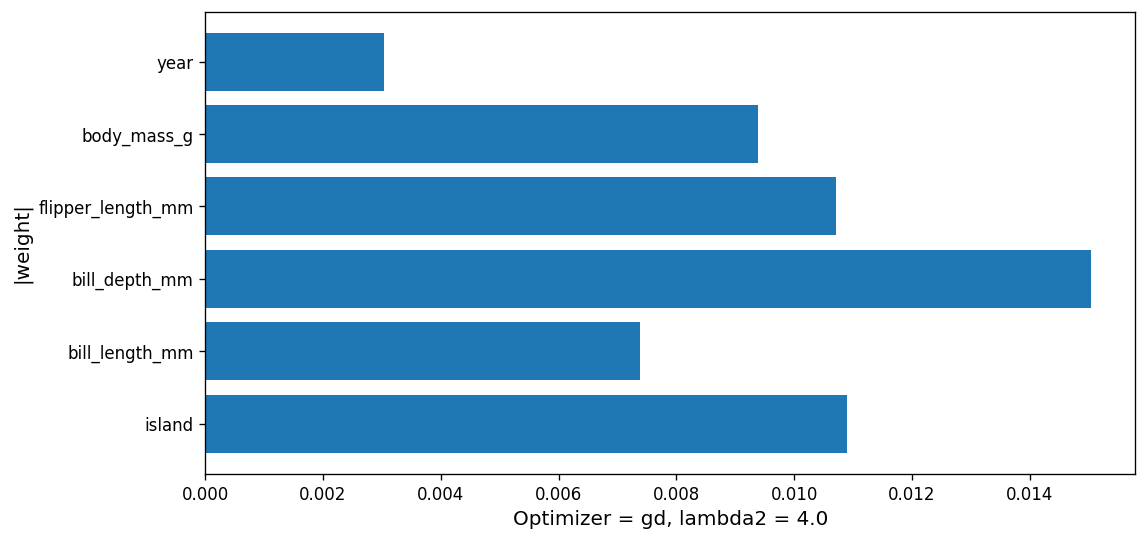

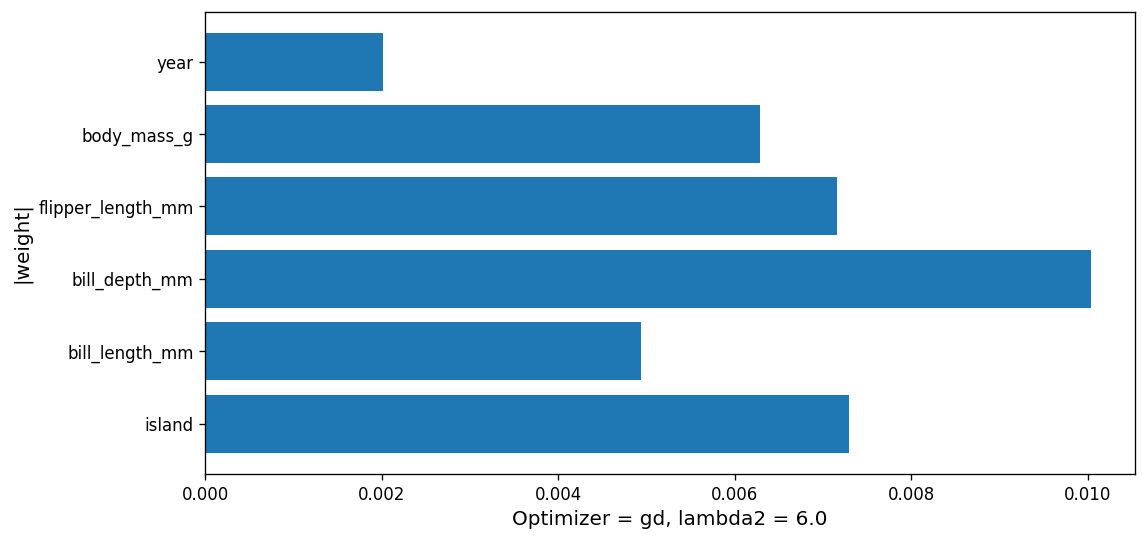

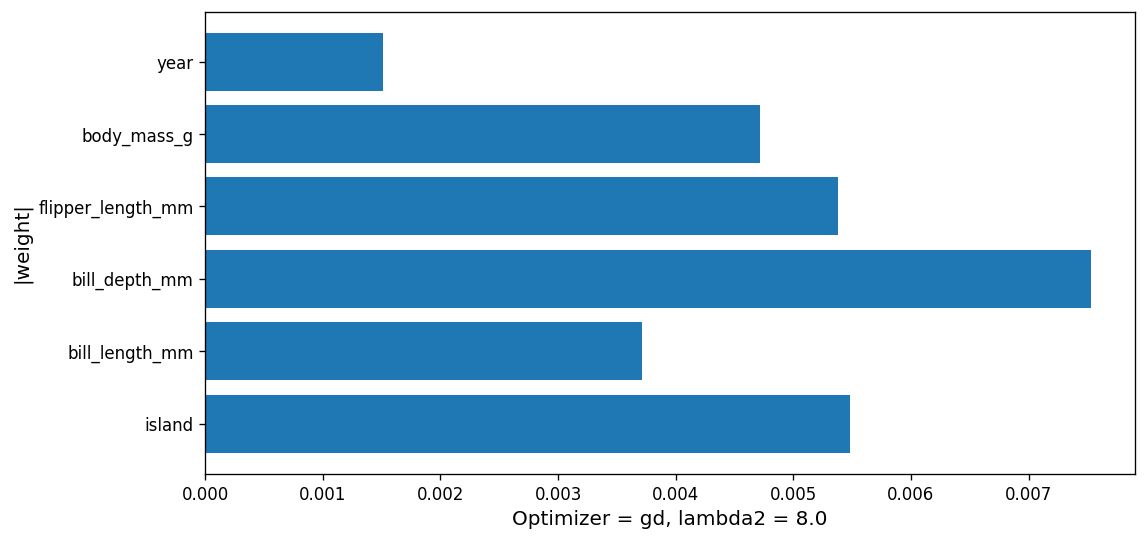

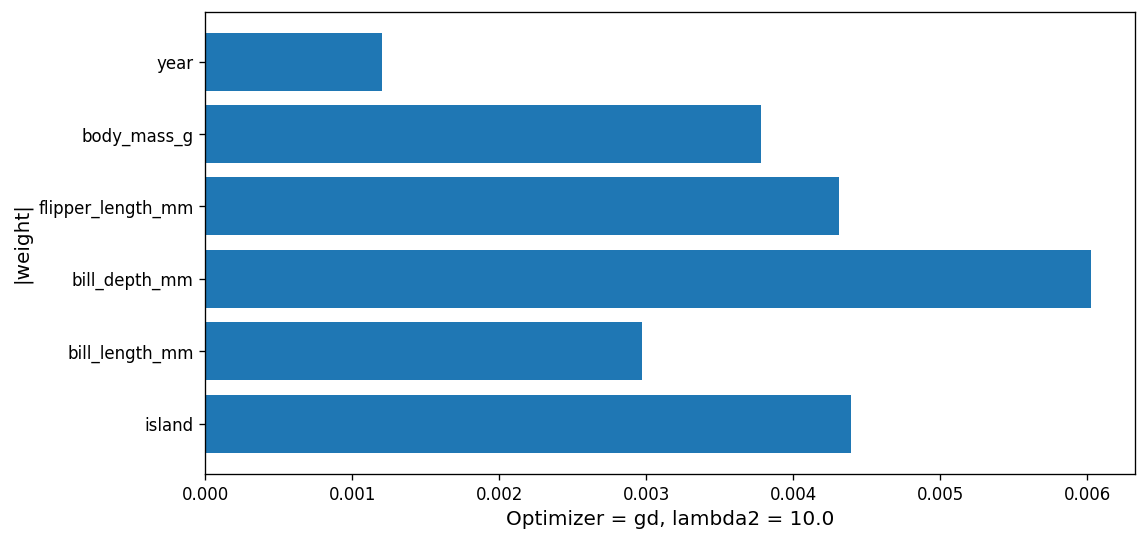

In [ ]:
lambdas1 = np.arange(0, 10.1, 0.2)

train_acc_gd, val_acc_gd, f1_score_gd, train_time_gd = [],[],[],[]

for l in lambdas1:
    model = MyBinaryLogisticRegression('l2', 'gd', 1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time_gd.append(time.time() - t)

    score = model.score(X_test, y_test)
    f1_score_gd.append(score)
    val_acc_gd.append(accuracy_score(y_test, model.predict(X_test)))
    train_acc_gd.append(accuracy_score(y_train, model.predict(X_train)))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_[1:].flatten()))
        plt.xlabel("Optimizer = gd, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

Видим, что для всех методов наиболее значим признак bill_depth_mm, наименее - year

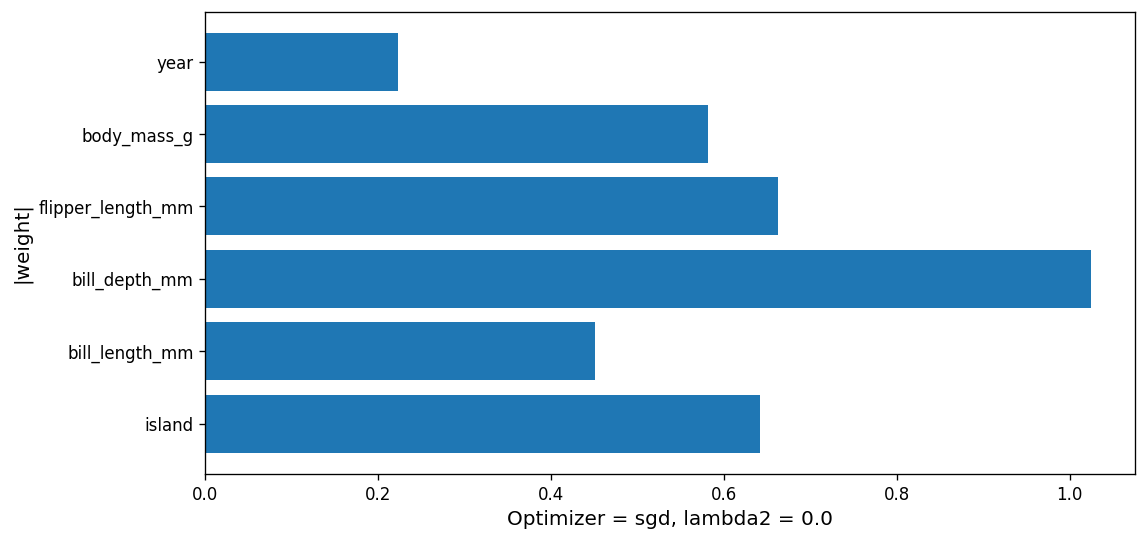

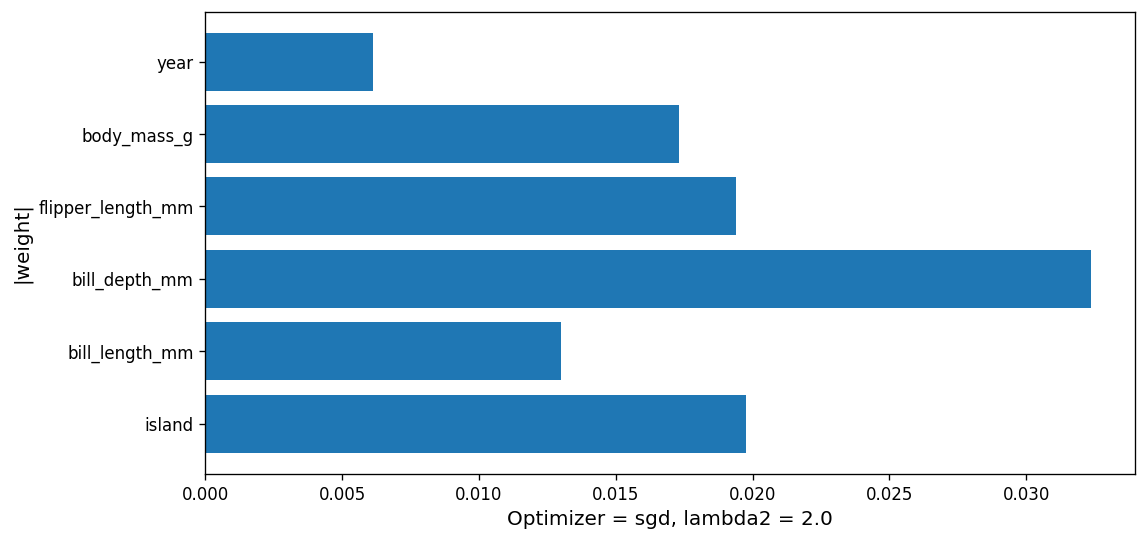

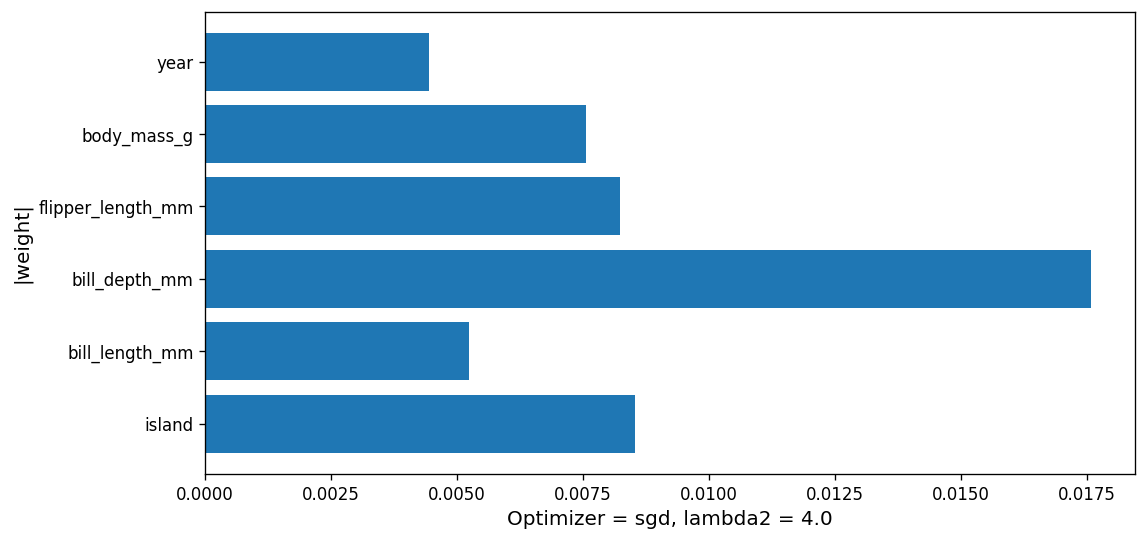

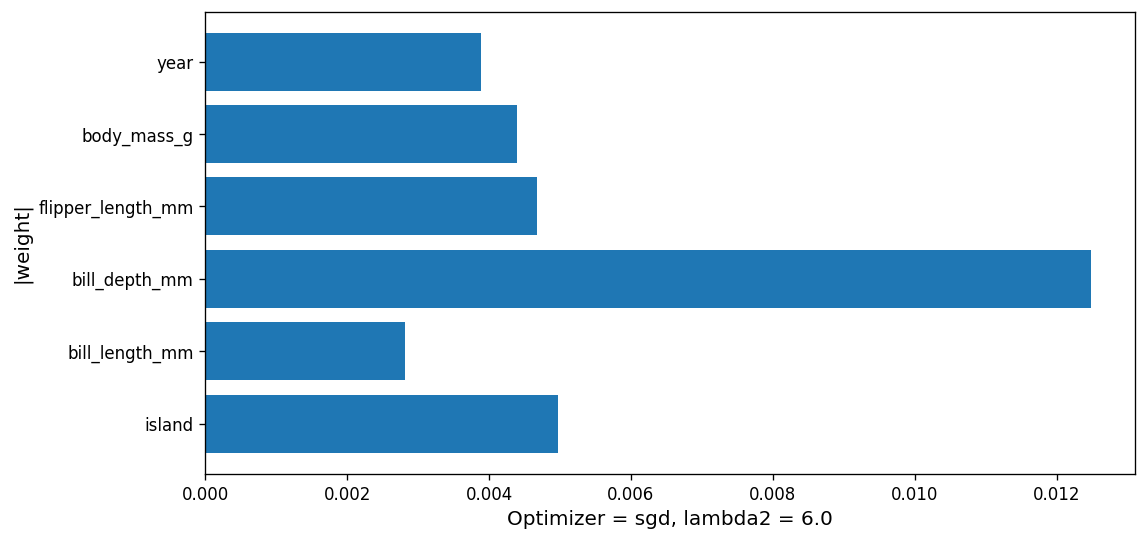

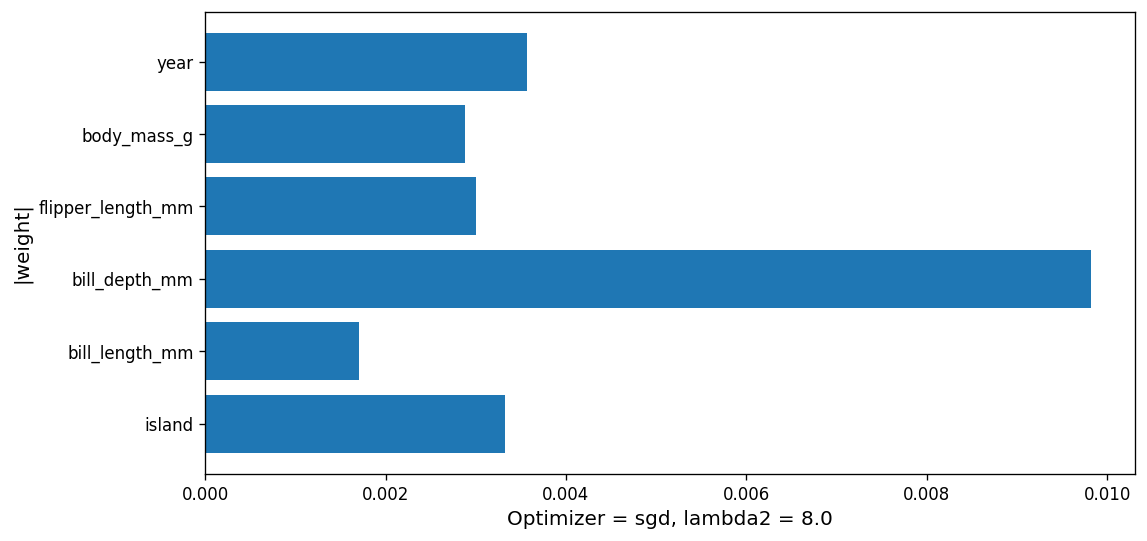

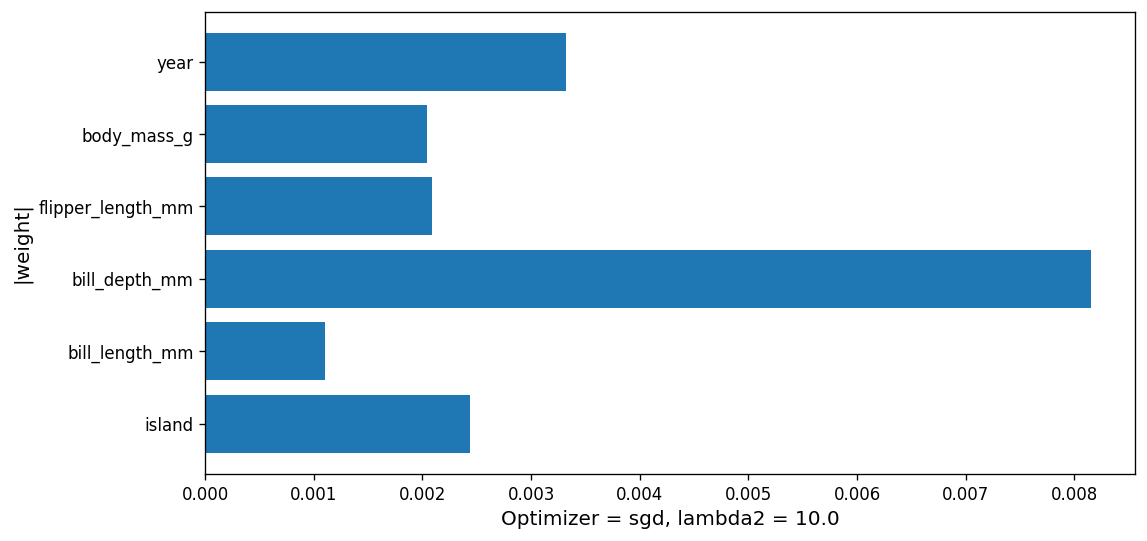

In [ ]:
lambdas1 = np.arange(0, 10.1, 0.2)

train_acc_sgd, val_acc_sgd, f1_score_sgd, train_time_sgd = [],[],[],[]

for l in lambdas1:
    model = MyBinaryLogisticRegression('l2', 'sgd', 1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time_sgd.append(time.time() - t)

    score = model.score(X_test, y_test)
    f1_score_sgd.append(score)
    val_acc_sgd.append(accuracy_score(y_test, model.predict(X_test)))
    train_acc_sgd.append(accuracy_score(y_train, model.predict(X_train)))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_[1:].flatten()))
        plt.xlabel("Optimizer = sgd, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

Text(0, 0.5, 'Accuracy')

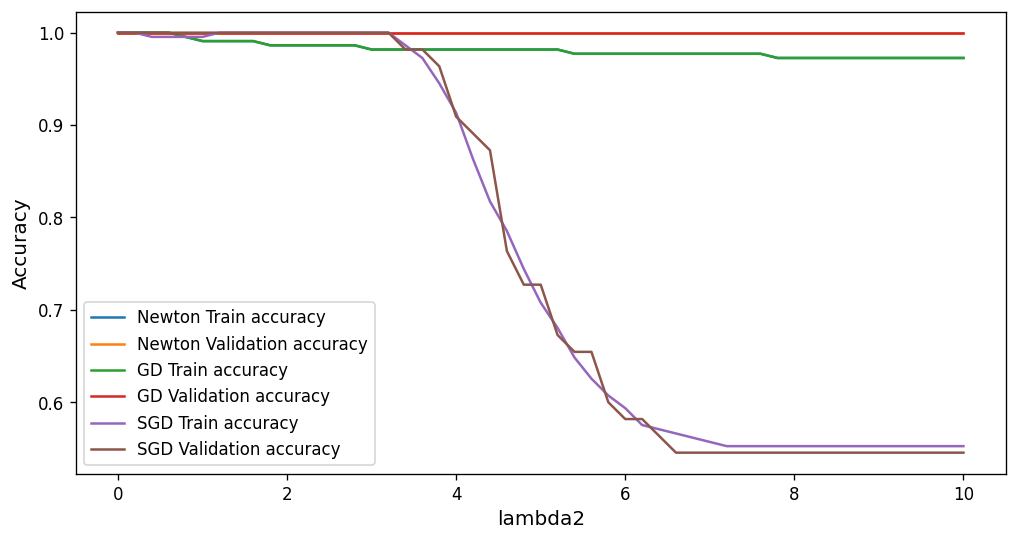

In [ ]:
plt.plot(lambdas1, train_acc_new, label = 'Newton Train accuracy')
plt.plot(lambdas1, val_acc_new, label = 'Newton Validation accuracy')
plt.plot(lambdas1, train_acc_gd, label = 'GD Train accuracy')
plt.plot(lambdas1, val_acc_gd, label = 'GD Validation accuracy')
plt.plot(lambdas1, train_acc_sgd, label = 'SGD Train accuracy')
plt.plot(lambdas1, val_acc_sgd, label = 'SGD Validation accuracy')
plt.legend()
plt.xlabel('lambda2')
plt.ylabel('Accuracy')

Text(0, 0.5, 'f1 score')

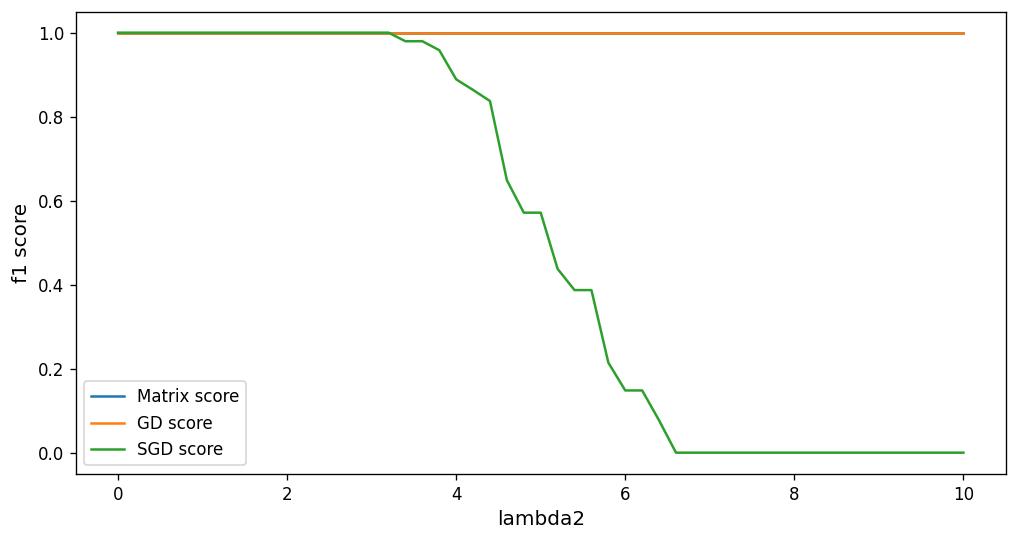

In [ ]:
plt.plot(lambdas1, f1_score_new, label = 'Matrix score')
plt.plot(lambdas1, f1_score_gd, label = 'GD score')
plt.plot(lambdas1, f1_score_sgd, label = 'SGD score')

plt.legend()
plt.xlabel('lambda2')
plt.ylabel('f1 score')

Все методы показывают хорошие результаты (возможно даже слишком). Однако при больших lambda у sgd сильно падают метрики.

Text(0, 0.5, 'Time')

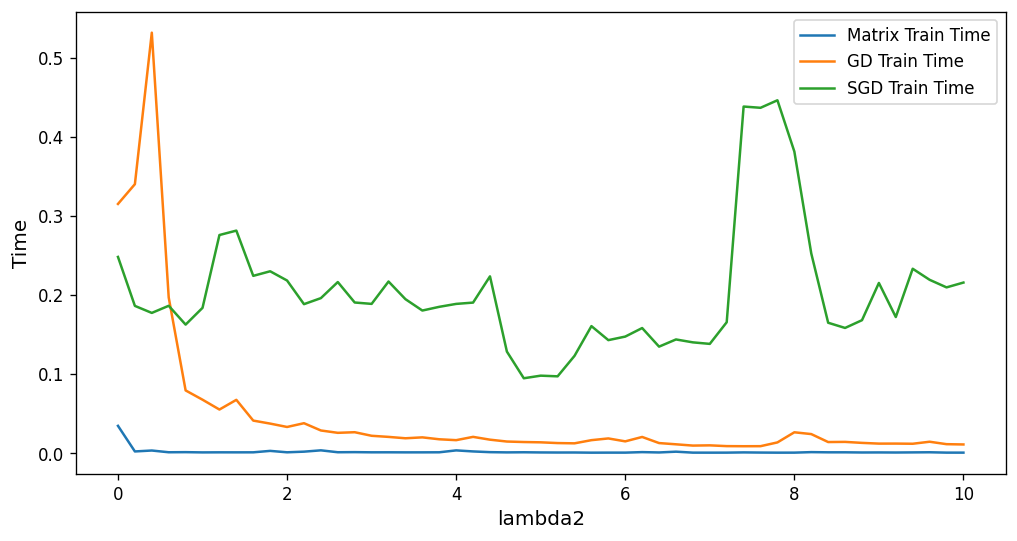

In [ ]:
plt.plot(lambdas1, train_time_new, label = 'Matrix Train Time')
plt.plot(lambdas1, train_time_gd, label = 'GD Train Time')
plt.plot(lambdas1, train_time_sgd, label = 'SGD Train Time')

plt.legend()
plt.xlabel('lambda2')
plt.ylabel('Time')

В среднем алгоритм сходится довольно быстро, но sgd как обычно работает дольше.

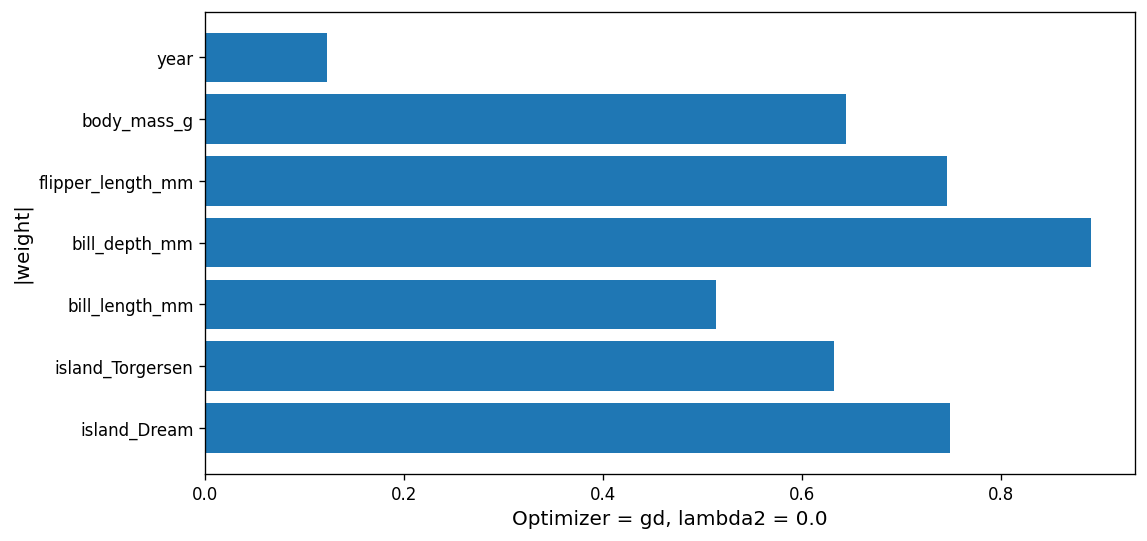

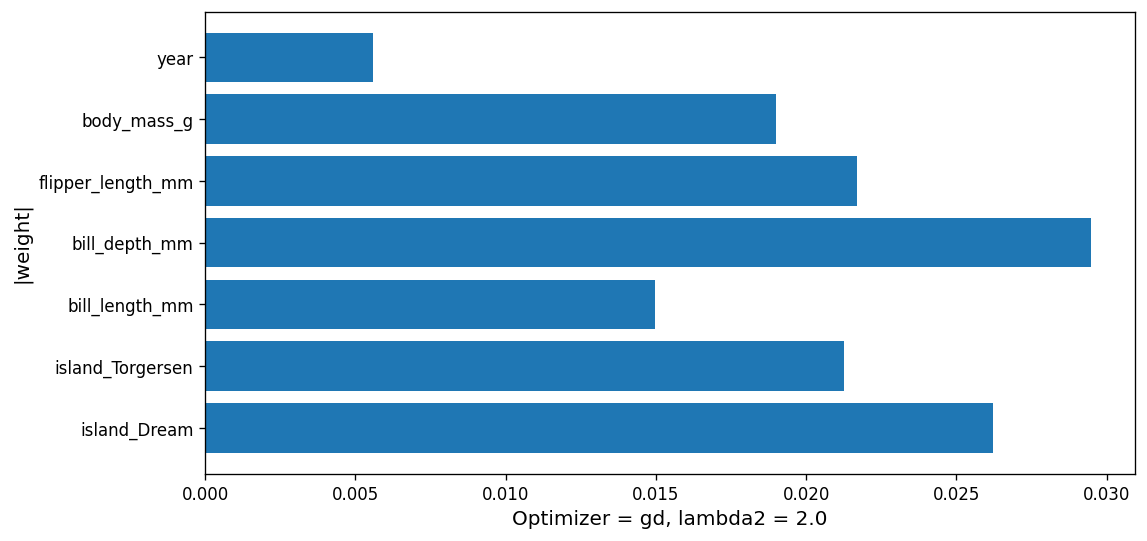

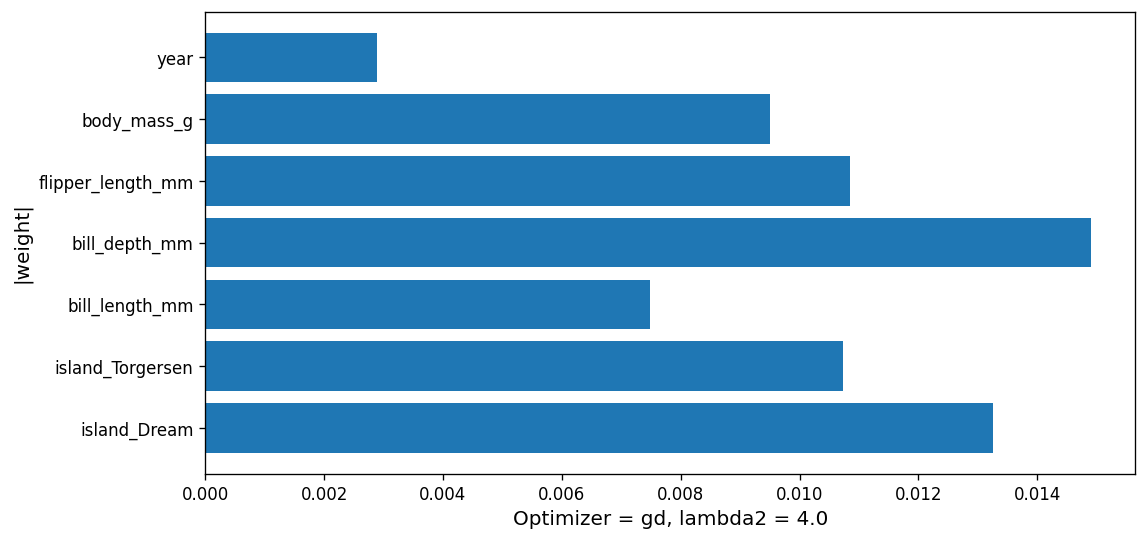

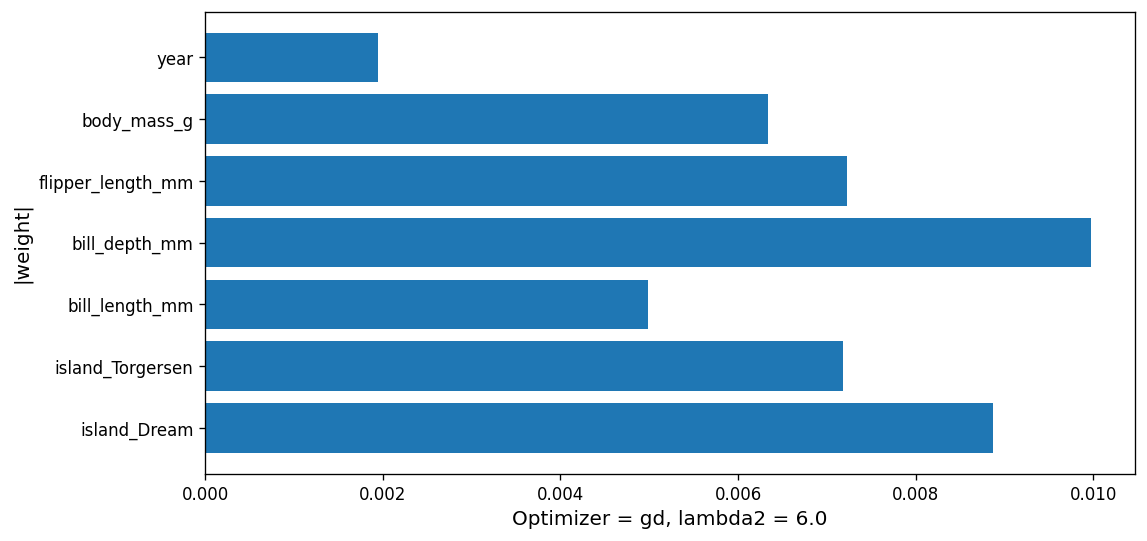

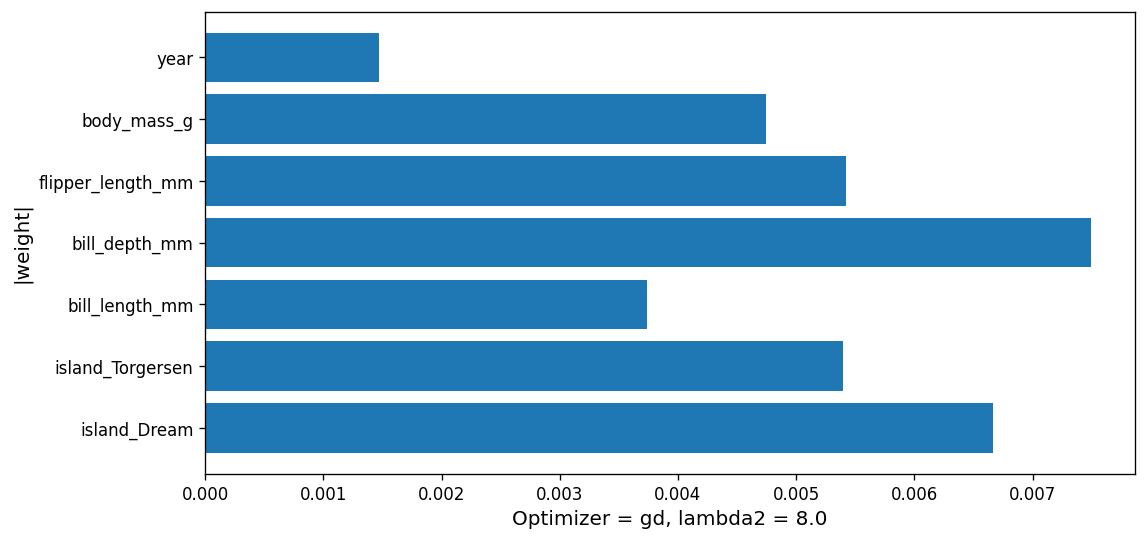

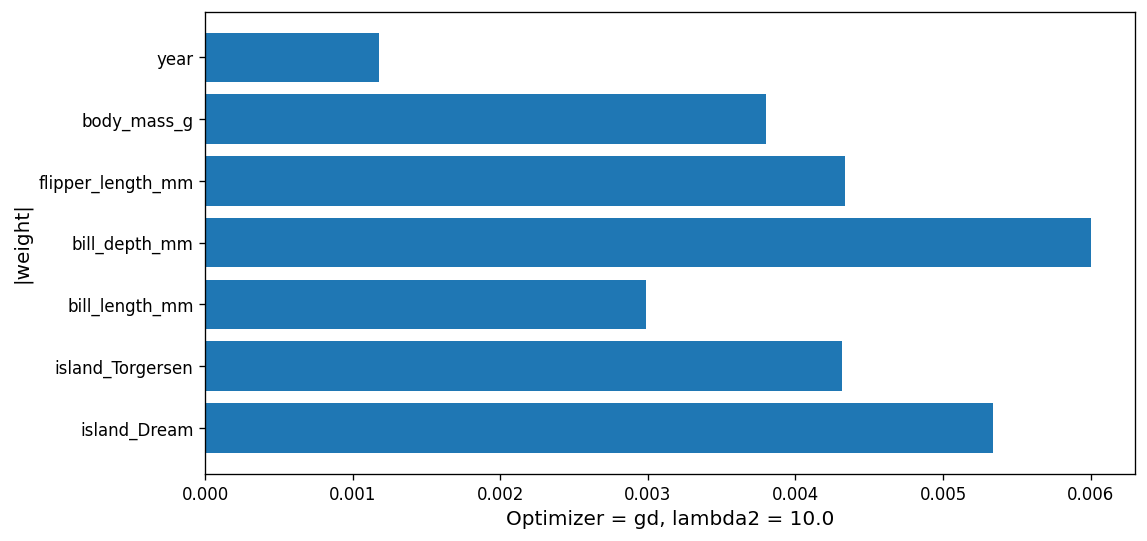

In [ ]:
#сравним с one hot
X, y = df.drop(columns=['species']), df[['species']]
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

scaler = MinMaxScaler()
y_encoder = OneHotEncoder(drop='first', sparse_output=False)
X, y = df.drop(columns=['species']), df[['species']]

y = y_encoder.fit_transform(y)
y = pd.DataFrame(y, columns=y_encoder.get_feature_names_out())
X_cat_cols = y_encoder.fit_transform(X[cat_cols], y)
X_num_cols = scaler.fit_transform(X[num_cols])

X_cat_cols = pd.DataFrame(X_cat_cols, columns=y_encoder.get_feature_names_out())
X_num_cols = pd.DataFrame(X_num_cols, columns=scaler.get_feature_names_out())
X = pd.concat([X_cat_cols, X_num_cols], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y['species_Gentoo'], test_size=0.2, random_state=42)

lambdas1 = np.arange(0, 10.1, 0.2)

train_acc, val_acc, f1_score, train_time = [],[],[],[]

for l in lambdas1:
    model = MyBinaryLogisticRegression('l2', 'gd', 1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time.append(time.time() - t)

    score = model.score(X_test, y_test)
    f1_score.append(score)
    val_acc.append(accuracy_score(y_test, model.predict(X_test)))
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_[1:].flatten()))
        plt.xlabel("Optimizer = gd, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

Text(0, 0.5, 'Accuracy')

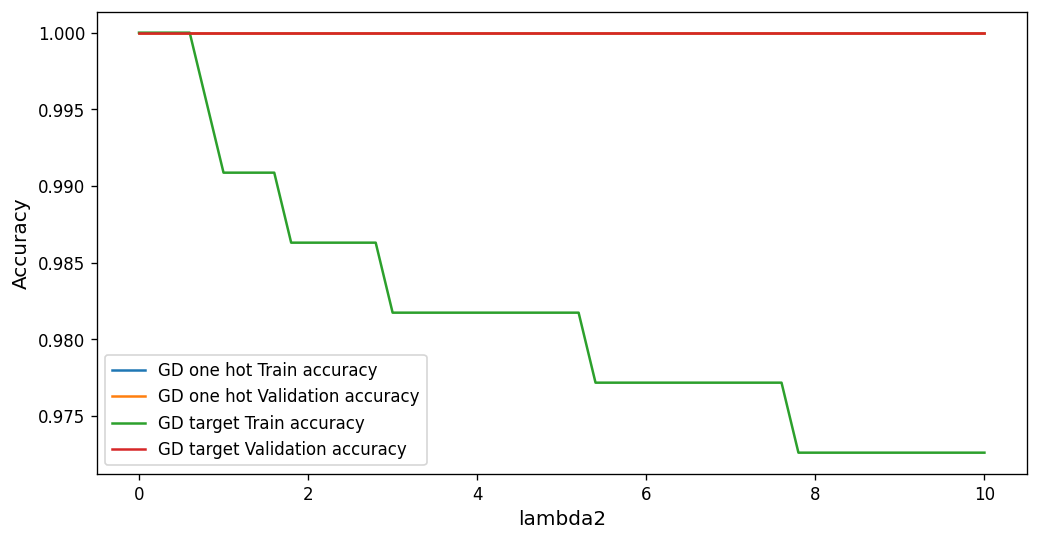

In [ ]:
plt.plot(lambdas1, train_acc, label = 'GD one hot Train accuracy')
plt.plot(lambdas1, val_acc, label = 'GD one hot Validation accuracy')
plt.plot(lambdas1, train_acc_gd, label = 'GD target Train accuracy')
plt.plot(lambdas1, val_acc_gd, label = 'GD target Validation accuracy')

plt.legend()
plt.xlabel('lambda2')
plt.ylabel('Accuracy')

Text(0, 0.5, 'f1 score')

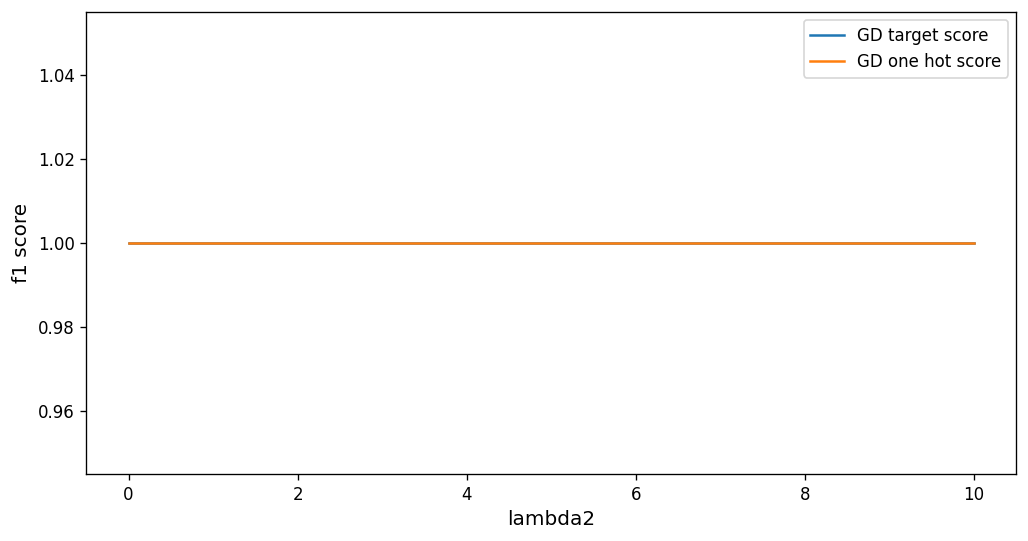

In [ ]:
plt.plot(lambdas1, f1_score_gd, label = 'GD target score')
plt.plot(lambdas1, f1_score, label = 'GD one hot score')

plt.legend()
plt.xlabel('lambda2')
plt.ylabel('f1 score')

На таком датасете разницы не видно

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

<p>1. Функция потерь</p>
<p>$P(C_j|x_i) = p_{ij}$</p>
<p>Возьмем логарифм функции правдоподобия: $log\mathbb P(D|\omega) = \sum_{i = 1}^{N}\sum_{j = 1}^M \mathbb {y_{ij}}log(p_{ij})$</p>
<p>Таким образом функция потерь: $L(\omega) = -\sum_{i = 1}^{N}\sum_{j = 1}^M \mathbb {y_{ij}}log(p_{ij})$</p>
<p>В матричном виде: $L(\omega) = -tr(Y^Tlog(softmax(X\omega^T))$</p>
<p>2. Градиент функции потерь</p>
<p>$\frac{dL}{d\omega_j} = \sum_{i=1}^N(p_{ij} - y_{ij})x_i$</p>
<p>В матричном виде: $\nabla_{\omega}L = (softmax(X\omega^T) - Y)^TX$</p>
<p>3. Гессиан</p>
<p>Для блоков матрицы гессиана (j,k):</p>
<p>$H_{jk} = \sum_{i = 1}^Np_{ij}(\delta_{jk}-p_{ik})x_ix_i^T$</p>
<p>4. Разделяющая гиперплоскость</p>
<p>$(\omega_j - \omega_k)^Tx = 0$</p>


In [ ]:
#Генерируем синтетические данные
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 120,
})

np.random.seed(42)

N = 600
M = 3
d = 3

X_raw = np.vstack([
    np.random.randn(N//3, 2) + np.array([2, 2]),
    np.random.randn(N//3, 2) + np.array([-2, 2]),
    np.random.randn(N//3, 2) + np.array([0, -2])
])

y = np.array([0]*(N//3) + [1]*(N//3) + [2]*(N//3))

X = np.hstack([np.ones((N, 1)), X_raw])

Y = np.zeros((N, M))
Y[np.arange(N), y] = 1

In [ ]:
#softmax, функция потерь и градиент
def softmax(Z):
    Z = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def loss(W, X, Y):
    Z = X @ W.T
    P = softmax(Z)
    return -np.sum(Y * np.log(P + 1e-12))

def gradient(W, X, Y):
    Z = X @ W.T
    P = softmax(Z)
    return (P - Y).T @ X

In [ ]:
#Обучение
W = np.zeros((M, d))

lr = 0.01
epochs = 1000

for epoch in range(epochs):
    grad = gradient(W, X, Y)
    W -= lr * grad





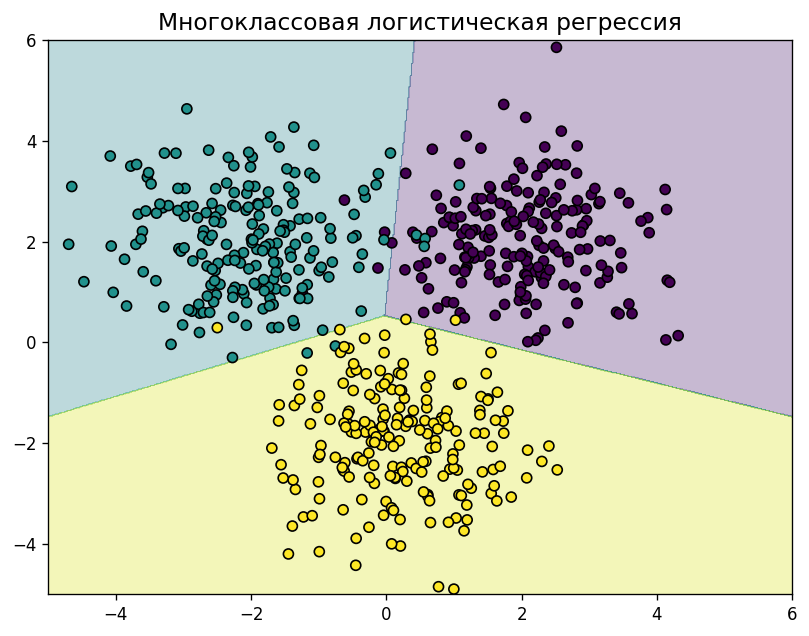

In [ ]:
#Классификация и визуализация результатов
xx, yy = np.meshgrid(
    np.linspace(-5, 6, N),
    np.linspace(-5, 6, N)
)

grid = np.c_[np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()]
Z = grid @ W.T
P = softmax(Z)
preds = np.argmax(P, axis=1)
preds = preds.reshape(xx.shape)


plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, preds, alpha=0.3)
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, edgecolor='k')
plt.title("Многоклассовая логистическая регрессия")
plt.show()

Объяснение: сначала вычисляем линейные оценки Z для каждого класса (гиперплоскости), дальше с помощью softmax переводим их в вероятности для каждого класса и в качестве оценки класса объекта выбираем тот, у которого наибольшая вероятность. $\omega_j$ - это вектор нормали класса, который мы хотим найти с помощью градиентного спуска, максимизируя $\omega_j^Tx$.
Эта схема работает, потому что мы оптимизируем выпуклую функцию (кросс-энтропию) и модель ищет гиперплоскости максимизирующие правдоподобие классов.